# CME vs stETH prices

### Functions

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def show_scatter(dataset, tf):

    # Set the size of the plot
    plt.figure(figsize=(10, 6))  # Width and height in inches

    # Add regression line
    sns.regplot(x='Price_steth', y='Price_cme', data=dataset, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})

    # Plotting the dataset
    sns.scatterplot(x='Price_steth', y='Price_cme', data=dataset)
    plt.title(f'Scatter Plot of CME Price vs stEth Price on {tf} timeframe')
    plt.xlabel('Price CME')
    plt.ylabel('Price stEth')
    plt.show()


In [3]:
def remove_outliers(df):
    for col in ['Price_cme','Price_steth']:
        # Calculate the 99th percentile
        upper_limit = df[col].quantile(0.99)

        # Filter the dataset to remove extreme outliers
        filtered_df = df[df[col] <= upper_limit]
    return filtered_df

In [4]:
def show_pearson_coef(df):
    # Calculate the Pearson correlation coefficient
    correlation_coefficient = df['Price_cme'].corr(df['Price_steth'])
    print("Pearson Correlation Coefficient:", correlation_coefficient)

### Datasets

In [5]:
import pandas as pd

col_names = ['Entry Date UTC', 'Price']

# Load csv files for CME data
cme_data_1h = pd.read_csv('../data/cme/cme_1h.csv', usecols=col_names)
cme_data_5m = pd.read_csv('../data/cme/cme_5m.csv', usecols=col_names)
cme_data_1m = pd.read_csv('../data/cme/cme_1m.csv', usecols=col_names)

# Date conversion & remove outliers
for df in (cme_data_1h, cme_data_5m, cme_data_1m):
    df['Entry Date UTC'] = pd.to_datetime(df['Entry Date UTC'], format='%Y%m%dT%H:%M:%S')

# Load csv files for stEth data
steth_data_1h = pd.read_csv('../data/steth/steth_1h.csv', usecols=col_names)
steth_data_5m = pd.read_csv('../data/steth/steth_5m.csv', usecols=col_names)
steth_data_1m = pd.read_csv('../data/steth/steth_1m.csv', usecols=col_names)

# Date conversion & remove outliers
for df in (steth_data_1h, steth_data_5m, steth_data_1m):
    df['Entry Date UTC'] = pd.to_datetime(df['Entry Date UTC'])

# Merge datasets using date
dataset_1h = pd.merge(cme_data_1h, steth_data_1h, on='Entry Date UTC', suffixes=('_cme', '_steth'))
dataset_5m = pd.merge(cme_data_5m, steth_data_5m, on='Entry Date UTC', suffixes=('_cme', '_steth'))
dataset_1m = pd.merge(cme_data_1m, steth_data_1m, on='Entry Date UTC', suffixes=('_cme', '_steth'))

# Remove outliers
dataset_1h = remove_outliers(dataset_1h)
dataset_5m = remove_outliers(dataset_5m)
dataset_1m = remove_outliers(dataset_1m)

# dataset_1h = remove_outliers(dataset_1h)

print(dataset_1h.head())


       Entry Date UTC  Price_cme  Price_steth
0 2022-01-02 23:00:00     3822.5      3818.02
1 2022-01-03 00:00:00     3838.0      3818.02
2 2022-01-03 01:00:00     3812.0      3791.57
3 2022-01-03 02:00:00     3812.5      3796.46
4 2022-01-03 03:00:00     3807.5      3787.55


### Scatter Plots

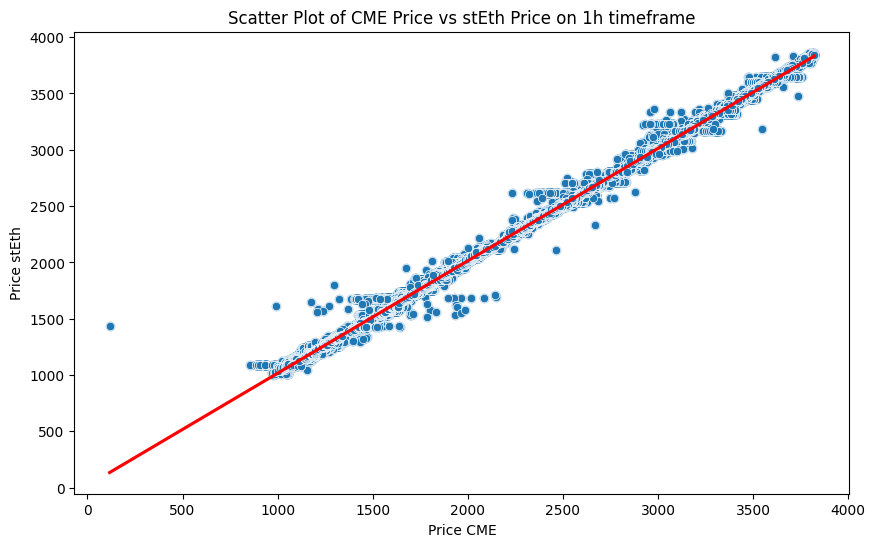

In [83]:
show_scatter(dataset_1h, '1h')

In [84]:
show_pearson_coef(dataset_1h)

Pearson Correlation Coefficient: 0.9985290823487663


In [85]:
dataset_1h.describe()

,Entry Date UTC,Price_cme,Price_steth
count,19333,19333.000000,19333.000000
mean,2023-02-28 01:12:02.681425408,2030.949620,2016.884270
min,2022-01-02 23:00:00,1003.000000,116.660000
25%,2022-08-01 09:00:00,1585.500000,1574.280000
50%,2023-02-27 14:00:00,1843.000000,1834.610000
75%,2023-09-25 18:00:00,2435.500000,2418.540000
max,2024-04-30 23:00:00,3861.500000,3821.190000
std,NaN,669.040271,669.379128


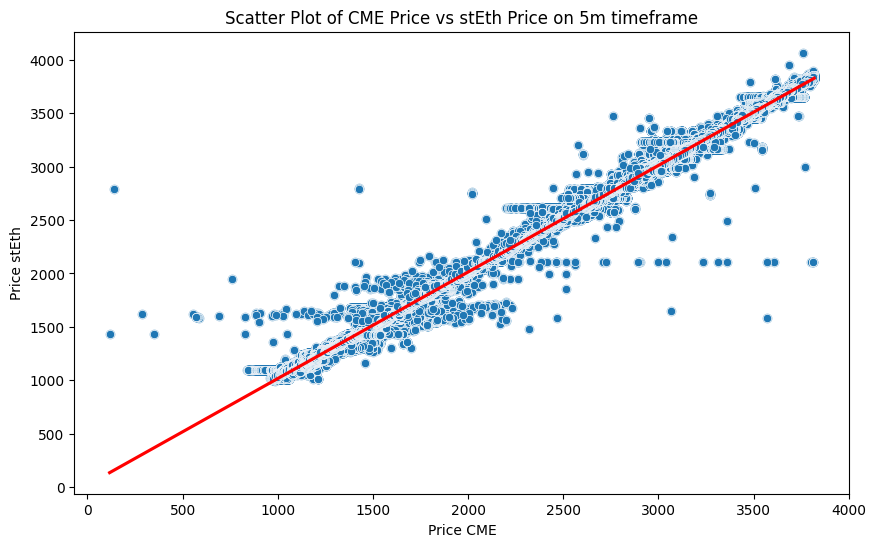

In [6]:
show_scatter(dataset_5m, '5m')

In [87]:
show_pearson_coef(dataset_5m)

Pearson Correlation Coefficient: 0.9983430191739039


In [42]:
dataset_5m.describe()

,Entry Date UTC,Price_cme,Price_steth,predicted,residuals,abs_residuals
count,232014,232014.000000,232014.000000,232014.000000,2.320140e+05,232014.000000
mean,2023-02-28 02:19:02.082805504,2030.667755,2016.751779,2016.751779,4.600511e-14,20.409924
min,2022-01-02 23:00:00,996.000000,116.660000,983.220676,-2.635940e+03,0.000412
25%,2022-08-01 10:31:15,1585.500000,1574.340000,1572.073071,-9.807692e+00,6.111904
50%,2023-02-27 16:17:30,1843.000000,1834.900000,1829.290190,4.734066e+00,12.686001
75%,2023-09-25 19:13:45,2436.000000,2417.847500,2421.638740,1.348195e+01,23.411187
max,2024-04-30 23:55:00,4067.000000,3818.020000,4050.846977,2.000915e+03,2635.940396
std,NaN,668.634897,669.008892,667.900357,3.849689e+01,32.641137


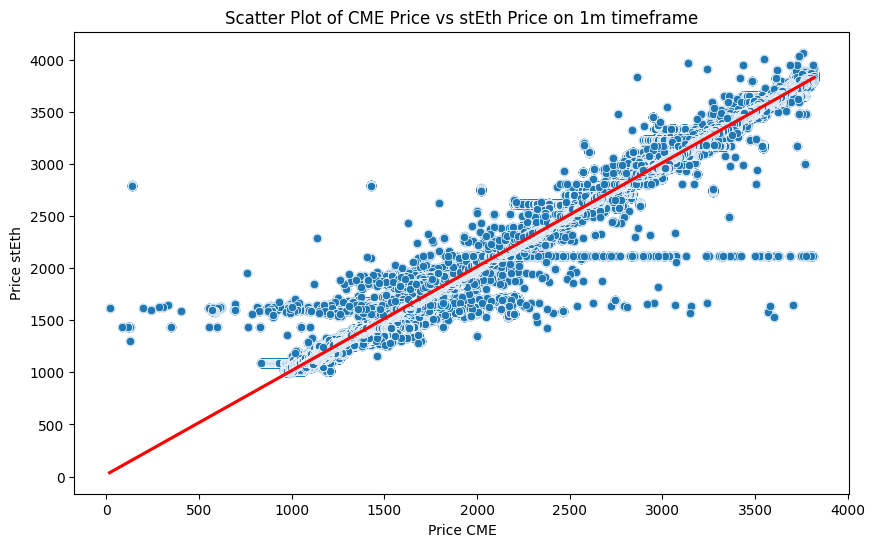

In [88]:
show_scatter(dataset_1m, '1m')

In [89]:
show_pearson_coef(dataset_1m)

Pearson Correlation Coefficient: 0.9983392919022325


### Outliers hunting

In [29]:
from sklearn.linear_model import LinearRegression

def show_outliers(df, n_times_sd):
    '''
    This function fits a linear regression model, calculates residuals, and prints rows where
    the absolute residuals exceed a specified number of standard deviations from the mean residual, 
    identifying these as outliers.
    '''
    # Fit the regression model
    model = LinearRegression()
    model.fit(df[['Price_cme']], df['Price_steth'])

    # Calculate predicted values
    df['predicted'] = model.predict(df[['Price_cme']])

    # Calculate residuals
    df['residuals'] = df['Price_steth'] - df['predicted']

    # Calculate the absolute residuals to determine the distance from the line
    df['abs_residuals'] = df['residuals'].abs()

    # Define a threshold
    std_dev = df['abs_residuals'].std()
    threshold = n_times_sd * std_dev

    # Filter rows where the absolute residuals are greater than the threshold
    outliers = df[df['abs_residuals'] > threshold]

    print(outliers[['Entry Date UTC', 'Price_cme', 'Price_steth', 'predicted', 'residuals']])


In [41]:
show_outliers(dataset_5m, 30)

            Entry Date UTC  Price_cme  Price_steth    predicted    residuals
8438   2022-02-02 12:10:00     2789.5       138.81  2774.750396 -2635.940396
8439   2022-02-02 12:15:00     2796.0      1428.11  2781.243256 -1353.133256
8440   2022-02-02 12:20:00     2792.0      1428.11  2777.247650 -1349.137650
71446  2022-09-18 17:50:00     1434.5       348.36  1421.238954 -1072.878954
71448  2022-09-18 18:00:00     1434.5       116.66  1421.238954 -1304.578954
105045 2023-01-18 12:50:00     1583.5      3570.99  1570.075268  2000.914732
110489 2023-02-07 06:30:00     1644.0      3067.71  1630.508804  1437.201196
171302 2023-09-15 13:15:00     1620.0       552.98  1606.535170 -1053.555170
171307 2023-09-15 13:40:00     1622.0       286.58  1608.532973 -1321.952973
173060 2023-09-21 22:45:00     1583.5       584.28  1570.075268  -985.795268
173189 2023-09-22 09:30:00     1593.0       583.06  1579.564831  -996.504831
173444 2023-09-23 07:45:00     1588.5       570.16  1575.069775 -1004.909775